In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from pylab import rcParams
# rcParams['figure.figsize'] = 10, 8
# rcParams['figure.dpi'] = 300


from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [3]:
import sklearn
Y = sklearn.datasets.make_moons(n_samples=100, shuffle=True, noise=None, random_state=None)[0]
Y = Y[np.argsort(Y[:,0]),]
Y += np.random.normal(0,0.01, Y.shape)

In [4]:
p = Y.shape[0]

n = Y.shape[1]

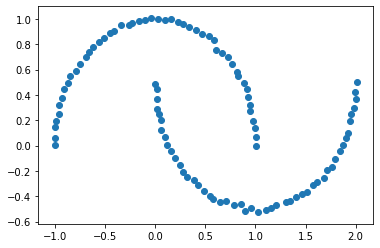

In [5]:
plt.scatter(Y[:,0],Y[:,1])

In [6]:
Adj0 = np.zeros([p,p])

In [7]:
for i in range(p):
    for j in range(i):
        Adj0[i,j] = np.sum((Y[i]-Y[j])**2)
#         Adj0[i,j] = np.sum(np.abs(Y[i]-Y[j])) 
        Adj0[j,i] = Adj0[i,j]

In [8]:
def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return int(k/ncol), k%ncol

In [9]:
def FindMST(A):

    p = A.shape[0]
    MST = np.zeros([p,p])

    Xl = list()
    Vl = list(range(p))
    Xl.append(0)
    Vl.remove(0)

    i = 0
    while len(Vl)>0:
        idx0, idx1 = find_min_idx(A[Xl][:,Vl])

        MST[Xl[idx0],Vl[idx1]]=1

        Xl.append(Vl[idx1])
        Vl.remove(Vl[idx1])

        i+=1
    
    return MST + MST.T

In [10]:
MST = FindMST(Adj0)
mst0 = MST.copy()

In [11]:
def getB(A):
    p = A.shape[0]

    B = np.zeros([p,p-1])

    idx = 0
    for i in range(p):
        for j in range(i):
            if A[i,j]==1:
                B[i,idx]=1
                B[j,idx]=-1
                idx+=1
    return B

In [12]:
def getA(B):
    A = - B@B.T
    np.fill_diagonal(A,0)
    return A

In [13]:
A = MST
B = getB(A)

In [14]:
sigma2 = 1
logP =  -Adj0/sigma2/2.0

In [15]:
def findRowColIdx(idx,m1,m2):
    r = int(idx / m2)
    return (r,     idx - r*m2)

In [16]:
def updateB(B, logP):

    full_edge_idx = np.arange(p-1)
    full_node_idx = np.arange(p)

    for k in range(p-1):

        sel = full_edge_idx==k
        sel_not = full_edge_idx!=k
        B_not_k = B[:,sel_not]
        B_k = B[:, sel]

        beta_k = (np.eye(p) - B_not_k@np.linalg.inv(B_not_k.T@B_not_k)@B_not_k.T)@B_k
        beta_k = np.round(beta_k.flatten(),10)

        unique_values = list(set(beta_k))

        if len(unique_values)!=2:
            print("error")

        subgraph0 = beta_k==unique_values[0]
        subgraph1 = beta_k==unique_values[1]

        subgraph0_node_idx = full_node_idx[subgraph0]
        subgraph1_node_idx = full_node_idx[subgraph1]

        logp_choices =  logP[subgraph0_node_idx,:][:,subgraph1_node_idx]

        m1,m2 = logp_choices.shape
        logp_gumbel = logp_choices + np.random.gumbel(0,1, logp_choices.shape)
        idx = np.argmax(logp_gumbel)

        r_idx, c_idx = findRowColIdx(idx,m1,m2)


        new_idx0= subgraph0_node_idx[r_idx]
        new_idx1= subgraph1_node_idx[c_idx]

        B[:,k] = 0
        B[new_idx0,k]=1
        B[new_idx1,k]= - 1

    return B

In [17]:
    B = updateB(B,logP)


In [18]:
sigma2 = 0.1

In [19]:
B@B.T

array([[ 3., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  3.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  3., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [20]:
import copy

In [21]:
A_trace = list()

In [22]:
for k in range(1000):
    
    sigma2 = 1/ np.random.gamma((p-1)*n/2 + 1 , 1.0/ ( np.sum(A*Adj0)/2/2 + 1), 1)
    logP =  -Adj0/sigma2/2.0
    
    B = updateB(B,logP)
    A = getA(B)

    A_trace.append(A.copy())
    
    if (k+1) % 100==0:
        print(k)
    
#     print(np.abs(A-mst0).sum())

99
199
299
399
499
599
699
799
899
999


In [23]:
mst_trace_arr = np.array(A_trace)

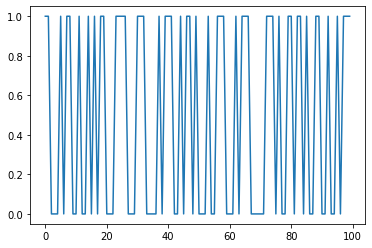

In [24]:
plt.plot(mst_trace_arr[:100,0,1])

In [25]:
mean_mst = mst_trace_arr.mean(0)

In [26]:
np.where(np.logical_and(mean_mst<0.7, mean_mst>0.3))

(array([ 0,  0,  1,  1,  2,  2,  2,  3, 25, 25, 26, 26, 27, 27, 27, 28, 71,
        71, 72, 72, 72, 73, 73, 73, 74, 74, 96, 97, 97, 98, 98, 98, 99, 99]),
 array([ 1,  2,  0,  2,  0,  1,  3,  2, 26, 27, 25, 27, 25, 26, 28, 27, 72,
        73, 71, 73, 74, 71, 72, 74, 72, 73, 98, 98, 99, 96, 97, 99, 97, 98]))

In [27]:
# plt.plot(mst_trace_arr[:100,96,97])

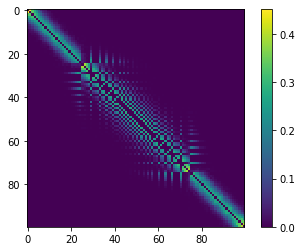

In [28]:
plt.imshow(mean_mst, vmin=0)
plt.colorbar()

In [33]:
sigma2

array([0.03091335])

In [31]:
import igraph

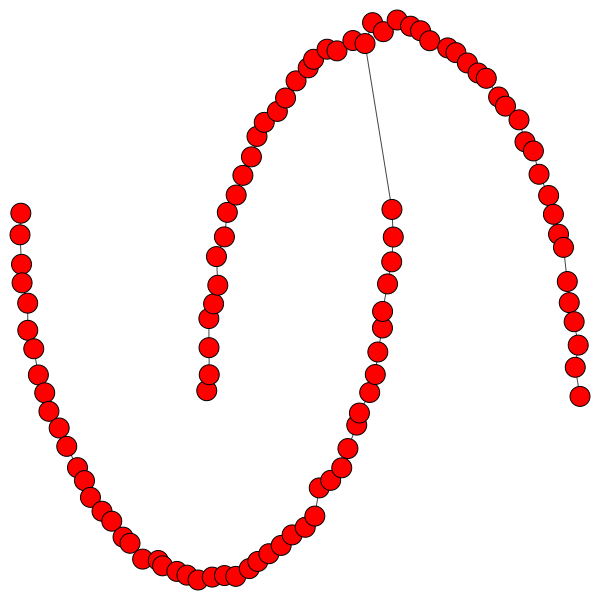

In [32]:
a= MST
np.fill_diagonal(a,0)
a= a.round()

g = igraph.Graph.Adjacency((a > 0).tolist())
g.to_undirected()

layout = zip(list(Y[:,0]), list(Y[:,1])) 
igraph.plot(g, layout = layout)